# Purely data-driven nodel trained with both displacement and stress fields

## Import packages

In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

## User defined neural network
* A fully-connected feed-forward network
    * **n_input** - dimension of input, 2 in this case(x and y lcation)
    * **n_output** - dimension of output, 1 in this case (u - horizontal or v - vertical displacemnt)
    * **n_layer** - number of hidden layers
    * **n_nodes** - number of nodes of each hidden layer

In [2]:
class Net(nn.Module):

    def __init__(self, n_input, n_output, n_layer, n_nodes):
        super(Net, self).__init__()
        self.n_layer = n_layer
        
        self.Input = nn.Linear(n_input, n_nodes)   # linear layer
        nn.init.xavier_uniform_(self.Input.weight) # wigths and bias initiation
        nn.init.normal_(self.Input.bias)

        self.Output = nn.Linear(n_nodes, n_output)
        nn.init.xavier_uniform_(self.Output.weight)
        nn.init.normal_(self.Output.bias)
        
        self.Hidden = nn.ModuleList() # hidden layer list
        for i in range(n_layer):
            self.Hidden.append(nn.Linear(n_nodes, n_nodes))
        for layer in self.Hidden:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.normal_(layer.bias)
        

    def forward(self, x):
        y = torch.tanh(self.Input(x)) # tanh activation function
        for layer in self.Hidden:
            y = torch.tanh(layer(y))
        y = self.Output(y)
        return y

In [3]:
def derivativs2(x, Net):
    
    w = Net(x)
    dw_x = []
    dw_y = []
    
    for i in range(w.size()[1]):
        
        #print(Net(x),func(x).view(-1,1),w)
        dw_xy = torch.autograd.grad(w[:,i], x, torch.ones_like(w[:,i]), retain_graph=True, 
                                    create_graph=True, allow_unused=True)
        dw_x.append(dw_xy[0][:,0].view(-1,1))
        dw_y.append(dw_xy[0][:,1].view(-1,1))

    return w, dw_x, dw_y

In [4]:
def loss_fcn(Net, X, Y):
     
    U_pred, dux, duy = derivativs2(X, Net)
    
    du_x, du_y = dux[0], duy[0]
    dv_x, dv_y = dux[1], duy[1]

    E, mu = 70, 0.3
    sig_x = (du_x + mu*dv_y)*E/(1 - mu**2) 
    sig_y = (dv_y + mu*du_x)*E/(1 - mu**2)
    sig_xy = (dv_x + du_y)*E/(1 + mu)/2.

    Y_pred = torch.cat((sig_x,sig_y,sig_xy), 1)
    
    loss = err(Y_pred, Y)
    
    return loss

## Preparing training data

In [5]:
data = pd.read_csv('CH-R2.csv')
X_train = data.iloc[:, 5:7].to_numpy()
U = data.iloc[:,11:13].to_numpy()
LE = data.iloc[:,13:16].to_numpy()
sig = data.iloc[:,16:19].to_numpy()
U1 = U[:,0].reshape(-1, 1)
U2 = U[:,1].reshape(-1, 1)
eps11 = LE[:,0].reshape(-1, 1)
eps22 = LE[:,1].reshape(-1, 1)
eps12 = LE[:,2].reshape(-1, 1)
sig11 = sig[:,0].reshape(-1, 1)
sig22 = sig[:,1].reshape(-1, 1)
sig12 = sig[:,2].reshape(-1, 1)

In [6]:
X_train = X_train/10
X_train = torch.tensor(X_train, dtype=torch.float32, requires_grad=True)
U = torch.tensor(U, dtype=torch.float32)
U = U / 10
Sig = torch.tensor(sig, dtype=torch.float32)

In [7]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, X, Y):
        
        self.X = X
        self.Y = Y
        
    def __len__(self):
        
        return len(self.X)

    def __getitem__(self, index):
        
        x = self.X[index]
        y = self.Y[index]

        return x, y

In [9]:
def err(X, Y):
    
    return torch.mean(torch.mean((X-Y)**2))

In [8]:
# Prepare training data
Net_u = Net(2, 2, 5, 5)

In [11]:
# Construct neural network
# optimizer
# optimizer
nepoches = 6000
learning_rate = 1.0e-4
optimizer = torch.optim.Adam(Net_u.parameters(), lr=learning_rate)
training_set = Dataset(X_train, Sig)
training_generator = torch.utils.data.DataLoader(training_set, batch_size= 128)
training_loss = []
sig_loss = []
for epoch in range(nepoches):
    
    for X_batch, Y_batch  in training_generator:
        
        U_pred = Net_u(X_train)
        
        loss_uv = err(U_pred, U)
        
        loss_sig = loss_fcn(Net_u, X_batch, Y_batch)
        
        loss = 100*loss_uv + loss_sig
        
        loss.backward()
         
        optimizer.step()
        optimizer.zero_grad()
        
    if (epoch+1) % 100 == 0:
        print(f'epoch:{epoch+1}: loss:{loss:.4e},loss1:{loss_uv:.4e},loss2:{loss_sig:.4e} ')
        
    if (epoch+1) % 10 == 0:
        
        U_pred = Net_u(X_train)
        
        loss = loss_fcn(Net_u, X_train, Sig)
        
        
        loss_uv = err(U_pred, U)
        
        training_loss.append(loss_uv)
        sig_loss.append(loss) 

epoch:100: loss:3.6806e-05,loss1:1.5711e-08,loss2:3.5235e-05 
epoch:200: loss:2.7236e-05,loss1:1.5003e-08,loss2:2.5736e-05 
epoch:300: loss:2.1949e-05,loss1:1.4407e-08,loss2:2.0508e-05 
epoch:400: loss:1.8800e-05,loss1:1.3934e-08,loss2:1.7407e-05 
epoch:500: loss:1.6774e-05,loss1:1.3546e-08,loss2:1.5419e-05 
epoch:600: loss:1.5348e-05,loss1:1.3206e-08,loss2:1.4027e-05 
epoch:700: loss:1.4274e-05,loss1:1.2910e-08,loss2:1.2982e-05 
epoch:800: loss:1.3405e-05,loss1:1.2652e-08,loss2:1.2140e-05 
epoch:900: loss:1.2661e-05,loss1:1.2419e-08,loss2:1.1419e-05 
epoch:1000: loss:1.2033e-05,loss1:1.2231e-08,loss2:1.0810e-05 
epoch:1100: loss:1.1531e-05,loss1:1.2225e-08,loss2:1.0308e-05 
epoch:1200: loss:1.1027e-05,loss1:1.2025e-08,loss2:9.8242e-06 
epoch:1300: loss:1.0681e-05,loss1:1.1912e-08,loss2:9.4899e-06 
epoch:1400: loss:1.0492e-05,loss1:1.1922e-08,loss2:9.2994e-06 
epoch:1500: loss:1.0392e-05,loss1:1.2028e-08,loss2:9.1890e-06 
epoch:1600: loss:1.0334e-05,loss1:1.2195e-08,loss2:9.1146e-06 
e

KeyboardInterrupt: 

In [12]:
X_train.requires_grad = True
U_pred, dux, duy = derivativs2(X_train, Net_u)

u1 = U_pred[:,0].reshape(-1,1)
u2 = U_pred[:,1].reshape(-1,1)
X = X_train[:,0].detach().numpy()*10
Y = X_train[:,1].detach().numpy()*10
U_pred = Net_u(X_train).detach().numpy()*10
u1 = U_pred[:,0].reshape(-1,1)
u2 = U_pred[:,1].reshape(-1,1)

In [13]:
max(u1)

array([0.17474204], dtype=float32)

In [14]:
np.corrcoef(U1.reshape(1,-1), u1.reshape(1,-1))

array([[1.        , 0.99973282],
       [0.99973282, 1.        ]])

In [15]:
np.corrcoef(U2.reshape(1,-1), u2.reshape(1,-1))

array([[1.        , 0.99849514],
       [0.99849514, 1.        ]])

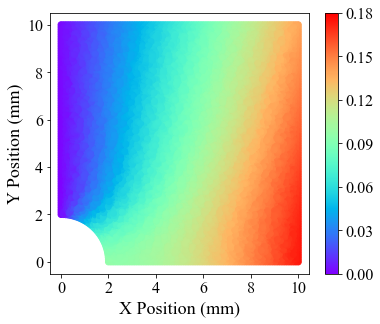

In [16]:
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = 'Times New Roman'
fig, ax = plt.subplots(figsize=(5.8, 4.8)) 
surf = ax.scatter(X, Y, c = u1, vmin=0, vmax=0.18, cmap=cm.rainbow)
#cbar = fig.colorbar(ax)
cb = fig.colorbar(surf, ticks=[0,0.03,0.06,0.09,0.12,0.15,0.18])
#cb.ax.locator_params(nbins=6)
cb.ax.tick_params(labelsize=16)
#cb.set_label(label =r'$\sigma_xx (MPa)$', fontsize=16)
#cb.set_label(fontsize=16)
ax.axis('equal')
ax.set_xlabel('X Position (mm)', fontsize=18)
ax.set_ylabel('Y Position (mm)', fontsize=18)
for tick in ax.get_xticklabels():
    #tick.set_fontname('Times New Roman')
    tick.set_fontsize(16)
for tick in ax.get_yticklabels():
    #tick.set_fontname('Times New Roman')
    tick.set_fontsize(16)
#plt.savefig('CH-R2-NN10-10.png', dpi=600, transparent=True)
plt.show()

In [18]:
du_x, du_y = dux[0], duy[0]
dv_x, dv_y = dux[1], duy[1]

E, mu = 70, 0.3
sig_x = (du_x + mu*dv_y)*E/(1 - mu**2) 
sig_y = (dv_y + mu*du_x)*E/(1 - mu**2)
sig_xy = (dv_x + du_y)*E/(1 + mu)/2.

#X = Xf[:,0].detach().numpy().reshape(-1,1)
#Y = Xf[:,1].detach().numpy().reshape(-1,1)

sig_x = sig_x.detach().numpy()
sig_y = sig_y.detach().numpy() 
sig_xy = sig_xy.detach().numpy()

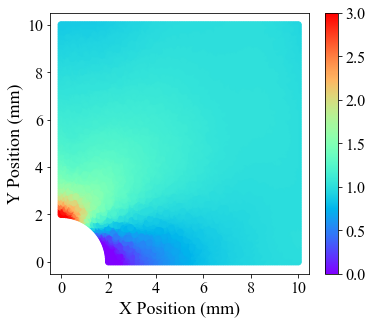

In [19]:
plt.rcParams['font.family'] = 'Times New Roman'
fig, ax = plt.subplots(figsize=(5.8, 4.8)) 
surf = ax.scatter(X, Y, c = sig_x, vmin=0, vmax=3.0, cmap=cm.rainbow)
#cbar = fig.colorbar(ax)
cb = fig.colorbar(surf)
cb.ax.locator_params(nbins=7)
cb.ax.tick_params(labelsize=16)
#cb.set_label(label =r'$\sigma_xx (MPa)$', fontsize=16)
#cb.set_label(fontsize=16)
ax.axis('equal')
ax.set_xlabel('X Position (mm)', fontsize=18)
ax.set_ylabel('Y Position (mm)', fontsize=18)
for tick in ax.get_xticklabels():
    #tick.set_fontname('Times New Roman')
    tick.set_fontsize(16)
for tick in ax.get_yticklabels():
    #tick.set_fontname('Times New Roman')
    tick.set_fontsize(16)
#plt.savefig('CH-R2-S-NN5-5-Stress.png', dpi=600, transparent=True)
plt.show()

In [20]:
np.corrcoef(sig12.reshape(1,-1), sig_xy.reshape(1,-1))

array([[1.        , 0.99048078],
       [0.99048078, 1.        ]])

In [21]:
np.corrcoef(sig11.reshape(1,-1), sig_x.reshape(1,-1))

array([[1.       , 0.9974195],
       [0.9974195, 1.       ]])

In [22]:
np.corrcoef(sig22.reshape(1,-1), sig_y.reshape(1,-1))

array([[1.        , 0.98427162],
       [0.98427162, 1.        ]])

In [23]:
data_out = np.hstack([X.reshape(-1,1),Y.reshape(-1,1),u1,u2,sig_x,sig_y,sig_xy])
df_out = pd.DataFrame(data_out, columns=['X', 'Y', 'U', 'V', 'Sig_x', 'Sig_y', 'Sig_xy'])

In [70]:
data_out = np.hstack([X.reshape(-1,1),Y.reshape(-1,1),U1,U2,sig11,sig22,sig12])
df_out = pd.DataFrame(data_out, columns=['X', 'Y', 'U', 'V', 'Sig_x', 'Sig_y', 'Sig_xy'])

In [24]:
df_out.to_csv('CH-R2-NN5-5-Stress.csv')